In [1]:
""" This file contains code for a fully convolutional
(i.e. contains zero fully connected layers) neural network
for detecting lanes. This version assumes the inputs
to be road images in the shape of 80 x 160 x 3 (RGB) with
the labels as 80 x 160 x 1 (just the G channel with a
re-drawn lane). Note that in order to view a returned image,
the predictions is later stacked with zero'ed R and B layers
and added back to the initial road image.
"""

import numpy as np
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Import necessary items from Keras
from keras.models import Sequential
from keras.layers import Activation, Dropout, UpSampling2D
from keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

# Load training images
train_images = pickle.load(open("full_CNN_train.p", "rb" ))

# Load image labels
labels = pickle.load(open("full_CNN_labels.p", "rb" ))

# Make into arrays as the neural network wants these
train_images = np.array(train_images)
labels = np.array(labels)

# Normalize labels - training images get normalized to start in the network
labels = labels / 255

# Shuffle images along with their labels, then split into training/validation sets
train_images, labels = shuffle(train_images, labels)
# Test size may be 10% or 20%
X_train, X_val, y_train, y_val = train_test_split(train_images, labels, test_size=0.1)

# Batch size, epochs and pool size below are all paramaters to fiddle with for optimization
batch_size = 128
epochs = 30
pool_size = (2, 2)
input_shape = X_train.shape[1:]

### Here is the actual neural network ###
model = Sequential()
# Normalizes incoming inputs. First layer needs the input shape to work
model.add(BatchNormalization(input_shape=input_shape))

# Below layers were re-named for easier reading of model summary; this not necessary
# Conv Layer 1
model.add(Conv2D(8, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv1'))

# Conv Layer 2
model.add(Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv2'))

# Pooling 1
model.add(MaxPooling2D(pool_size=pool_size))

# Conv Layer 3
model.add(Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv3'))
model.add(Dropout(0.2))

# Conv Layer 4
model.add(Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv4'))
model.add(Dropout(0.2))

# Conv Layer 5
model.add(Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv5'))
model.add(Dropout(0.2))

# Pooling 2
model.add(MaxPooling2D(pool_size=pool_size))

# Conv Layer 6
model.add(Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv6'))
model.add(Dropout(0.2))

# Conv Layer 7
model.add(Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv7'))
model.add(Dropout(0.2))

# Pooling 3
model.add(MaxPooling2D(pool_size=pool_size))

# Upsample 1
model.add(UpSampling2D(size=pool_size))

# Deconv 1
model.add(Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv1'))
model.add(Dropout(0.2))

# Deconv 2
model.add(Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv2'))
model.add(Dropout(0.2))

# Upsample 2
model.add(UpSampling2D(size=pool_size))

# Deconv 3
model.add(Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv3'))
model.add(Dropout(0.2))

# Deconv 4
model.add(Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv4'))
model.add(Dropout(0.2))

# Deconv 5
model.add(Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv5'))
model.add(Dropout(0.2))

# Upsample 3
model.add(UpSampling2D(size=pool_size))

# Deconv 6
model.add(Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv6'))

# Final layer - only including one channel so 1 filter
model.add(Conv2DTranspose(1, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Final'))

### End of network ###


# Using a generator to help the model use less data
# Channel shifts help with shadows slightly
datagen = ImageDataGenerator(channel_shift_range=0.2)
datagen.fit(X_train)

# Compiling and training the model
prank2 = model.compile(optimizer='Adam', loss='mean_squared_error', metrics = ['accuracy'])
prank = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=len(X_train)/batch_size,
epochs=epochs, verbose=1, validation_data=(X_val, y_val))

# Freeze layers since training is done
model.trainable = False
prank1 = model.compile(optimizer='Adam', loss='mean_squared_error')

# Save model architecture and weights
model.save('full_CNN_model.h5')

# Show summary of model
model.summary()




Using TensorFlow backend.


Epoch 1/30
90/89 [==============================] - 513s 6s/step - loss: 0.0605 - acc: 0.8963 - val_loss: 0.0305 - val_acc: 0.9458
Epoch 2/30
90/89 [==============================] - 510s 6s/step - loss: 0.0179 - acc: 0.9499 - val_loss: 0.0134 - val_acc: 0.9529
Epoch 3/30
90/89 [==============================] - 510s 6s/step - loss: 0.0128 - acc: 0.9540 - val_loss: 0.0103 - val_acc: 0.9559
Epoch 4/30
90/89 [==============================] - 509s 6s/step - loss: 0.0106 - acc: 0.9558 - val_loss: 0.0088 - val_acc: 0.9572
Epoch 5/30
90/89 [==============================] - 509s 6s/step - loss: 0.0094 - acc: 0.9567 - val_loss: 0.0081 - val_acc: 0.9575
Epoch 6/30
90/89 [==============================] - 509s 6s/step - loss: 0.0088 - acc: 0.9570 - val_loss: 0.0080 - val_acc: 0.9578
Epoch 7/30
90/89 [==============================] - 506s 6s/step - loss: 0.0083 - acc: 0.9575 - val_loss: 0.0069 - val_acc: 0.9593
Epoch 8/30
90/89 [==============================] - 505s 6s/step - loss: 0.0076 - a

Text(0.5, 0, 'epoch')

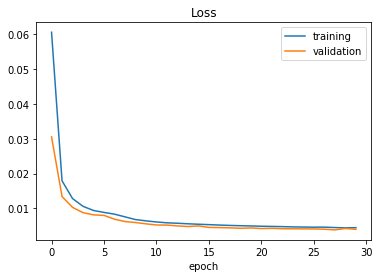

In [3]:
import matplotlib.pyplot as plt
plt.plot(prank.history['loss'])
plt.plot(prank.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

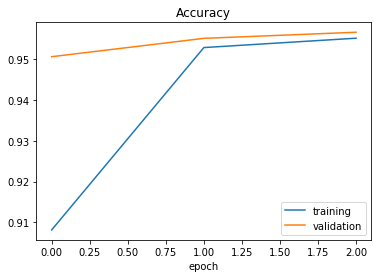

In [31]:
import matplotlib.pyplot as plt
plt.plot(prank.history['acc'])
plt.plot(prank.history['val_acc'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [1]:
import numpy as np
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Import necessary items from Keras
from keras.models import Sequential
from keras.layers import Activation, Dropout, UpSampling2D
from keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
train_images = pickle.load(open("full_CNN_train.p", "rb" ))

# Load image labels
labels = pickle.load(open("full_CNN_labels.p", "rb" ))

# Make into arrays as the neural network wants these
train_images = np.array(train_images)
labels = np.array(labels)







Using TensorFlow backend.


In [9]:
print(train_images.shape)
print(labels.shape)

print(labels[0:10, 0:10, 0:10])

(12764, 80, 160, 3)
(12764, 80, 160, 1)
[[[[0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]]]


 [[[0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
 